#### Repeating the Same Process - Ground Truth Climate & WNV Case Data 

We will see how actual climatic data compares with the embeddings. 

By: Angel Moreno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import warnings
import logging

from pytorch_tabnet.tab_model import TabNetRegressor
import shap

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from kneed import KneeLocator

import torch
import optuna 
from optuna.samplers import TPESampler

In [218]:
print("ran")

ran


#### Data Cleaning - Compiling 8 Clean CSVs Ready for Analysis 	

The goal of this section is to compile CSV files with predictor and target data ready for analysis for each of 2017 to 2024.

This involves the following:
* Climate Data
* Water Data
* NDVI Data
* County Population Data
* WNV Case Data

In [219]:
df_climate = pd.read_csv("../input/anuj_true_data_csvs/Angel_ClimateData.csv")

In [220]:
# climate data
df_climate = pd.read_csv("../input/anuj_true_data_csvs/Angel_ClimateData.csv")
# water data
df_water = pd.read_csv("../input/anuj_true_data_csvs/Angel_WaterData.csv")
# mean ndvi data
df_ndvi = pd.read_csv("../input/anuj_true_data_csvs/Angel_meanNDVI.csv")

This is my cleaned county populations data from 2017 to 2024. This was retreieved from https://Census.gov and cleaned further to have all of the years' population data in one CSV. 

Note: some population may not be readily available, as the availability of the data is a bit unpredictable. 

In [221]:
df_populations = pd.read_csv("../output/il_county_populations_2017_to_2024.csv").drop(columns=["Unnamed: 0"])
df_populations

,County,2017,2018,2019,2020,2021,2022,2023,2024
0,Adams,66057,65623,65435,65622,65077,64526,64435,64109
1,Alexander,6278,6041,5761,5172,5028,4859,4723,4594
2,Bond,16648,16637,16426,16856,16797,16716,16637,16576
3,Boone,53513,53480,53544,53339,53173,53084,53239,53313
4,Brown,6609,6563,6578,6237,6444,6321,6301,6307
...,...,...,...,...,...,...,...,...,...
97,Whiteside,55955,55553,55175,55574,55320,54602,54582,54657
98,Will,690479,691149,690743,696909,699327,699110,703383,708583
99,Williamson,67049,66982,66597,67121,66895,66565,66737,67064
100,Winnebago,284681,283630,282572,284963,283413,282081,282214,283790


Below, I am creating a case data table for all years 2017 to 2024. I have downloaded the county WNV case data files for 2017 to 2024, which are all up to date as of 12/27/25. 

This case data dataframe will be populated for 2017 to 2024.

In [222]:
df_cases = df_populations[["County"]]
df_cases

,County
0,Adams
1,Alexander
2,Bond
3,Boone
4,Brown
...,...
97,Whiteside
98,Will
99,Williamson
100,Winnebago


In [223]:
example_cases = pd.read_csv("../input/cases/Human Cases Map 2017.csv")
example_cases

,County,Cases
0,Adams,1
1,Boone,1
2,Carroll,1
3,Cook,52
4,Douglas,1
5,DuPage,6
6,Franklin,1
7,Jackson,2
8,Kane,2
9,Kankakee,2


In [224]:
for year in range(2017, 2025):	
	curr = pd.read_csv(f"../input/cases/Human Cases Map {year}.csv")
	curr = curr[curr["County"] != "Total"]
	curr = curr.rename(columns={"Cases": f"Cases_{year}"})
	df_cases = df_cases.merge(curr, on="County", how="left")
	df_cases[f"Cases_{year}"] = df_cases[f"Cases_{year}"].fillna(0).astype(int)

df_cases


,County,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
0,Adams,1,0,0,0,0,0,1,0
1,Alexander,0,0,0,0,0,0,0,0
2,Bond,0,1,0,0,0,0,0,0
3,Boone,1,0,0,0,0,0,0,0
4,Brown,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
97,Whiteside,0,1,0,0,0,0,0,0
98,Will,1,4,0,1,4,0,4,2
99,Williamson,0,1,0,0,1,0,0,0
100,Winnebago,3,1,0,0,0,0,2,4


The result below looks good (double checking with the data at https://dph.illinois.gov/topics-services/diseases-and-conditions/west-nile-virus/surveillance/human-cases-map.html?year=2024)

In [225]:
df_cases[df_cases["County"]=="Cook"]

,County,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
15,Cook,52,104,14,34,35,18,62,33


IMPORTANT: ``df_water`` does not have a geoid col or state col, thus I will concatenate horizontally to stay consistent with the ordering of ``df_climate`` and ``df_ndvi``. 

In [226]:
print(list(df_climate.County_1.unique()))
print(list(df_ndvi.County_1.unique()))

['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau', 'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark', 'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland', 'DeKalb', 'De Witt', 'Douglas', 'DuPage', 'Edgar', 'Edwards', 'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin', 'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson', 'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey', 'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox', 'Lake', 'LaSalle', 'Lawrence', 'Lee', 'Livingston', 'Logan', 'McDonough', 'McHenry', 'McLean', 'Macon', 'Macoupin', 'Madison', 'Marion', 'Marshall', 'Mason', 'Massac', 'Menard', 'Mercer', 'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria', 'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph', 'Richland', 'Rock Island', 'St. Clair', 'Saline', 'Sangamon', 'Schuyler', 'Scott', 'Shelby', 'Stark', 'Stephenson', 'Tazewell', 'Union', 'Vermilion', 'Wabash', 'Warren', 'W

In [227]:
list(df_climate.County_1.unique()) == list(df_ndvi.County_1.unique())

True

Now, I will check if my case and population county columns are consistent in ordering with the ordering of ``df_climate`` and ``df_ndvi``. 

In [228]:
df_climate

,County_1,FIPS,State,Population,X,Y,Hum_17,Pre_17,Tmax_17,Tmin_17,...,Hum_23,Pre_23,Tmax_23,Tmin_23,WS_23,Hum_24,Pre_24,Tmax_24,Tmin_24,WS_24
0,Adams,17001,Illinois,65435,-91.1848,39.9877,83.489720,2.414575,28.878265,16.430389,...,80.156819,2.598919,28.812063,16.643852,3.509917,86.957233,2.887003,28.874651,17.100551,3.662825
1,Alexander,17003,Illinois,5761,-89.3379,37.1964,92.409081,1.849715,29.800494,18.060720,...,92.354838,4.627896,29.968267,18.333393,2.979814,94.356359,3.490334,30.109471,18.601800,3.123587
2,Bond,17005,Illinois,16426,-89.4356,38.8868,87.526342,2.671293,29.578461,16.664752,...,87.931722,3.354472,28.878770,16.415715,3.666769,90.279601,3.576298,29.501770,17.693506,3.822610
3,Boone,17007,Illinois,53544,-88.8234,42.3231,94.299354,3.828716,26.579441,13.915454,...,84.941611,3.024114,26.706373,14.315155,3.842082,92.348444,3.880356,27.161379,14.746334,3.891934
4,Brown,17009,Illinois,6578,-90.7503,39.9618,86.754199,2.218834,28.874032,15.834936,...,83.882595,2.443424,28.595510,16.055039,3.595764,89.503626,3.176027,28.790812,16.788935,3.769309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195,Illinois,55175,-89.9123,41.7553,90.371500,3.071367,27.478812,14.891202,...,82.829832,2.374838,27.772224,15.295255,3.415740,89.602076,3.247248,27.904806,15.772279,3.454726
98,Will,17197,Illinois,690743,-87.9787,41.4450,91.886131,2.779096,27.584172,14.851429,...,87.019067,3.472279,27.124073,14.942312,3.475865,90.327146,3.290599,28.393179,15.664390,3.600911
99,Williamson,17199,Illinois,66597,-88.9299,37.7303,90.827954,2.335025,29.802950,17.611845,...,91.053690,4.186029,30.152616,17.835427,2.890200,92.386553,3.691179,30.178877,18.317548,2.992142
100,Winnebago,17201,Illinois,282572,-89.1608,42.3363,93.717256,3.636186,26.617381,14.118006,...,82.816904,2.648312,27.056700,14.645746,3.844946,91.906219,3.870281,27.436860,14.906896,3.896780


In [229]:
print(list(df_climate.County_1.unique()))
print(list(df_ndvi.County_1.unique()))
print(list(df_cases.County.unique()))
print(list(df_populations.County.unique()))

print(list(df_cases.County.unique()) == list(df_climate.County_1.unique()))
print(list(df_cases.County.unique()) == list(df_ndvi.County_1.unique()))

print(list(df_populations.County.unique()) == list(df_climate.County_1.unique()))
print(list(df_populations.County.unique()) == list(df_ndvi.County_1.unique()))
print(list(df_populations.County.unique()) == list(df_cases.County.unique()))

['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau', 'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark', 'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland', 'DeKalb', 'De Witt', 'Douglas', 'DuPage', 'Edgar', 'Edwards', 'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin', 'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson', 'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey', 'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox', 'Lake', 'LaSalle', 'Lawrence', 'Lee', 'Livingston', 'Logan', 'McDonough', 'McHenry', 'McLean', 'Macon', 'Macoupin', 'Madison', 'Marion', 'Marshall', 'Mason', 'Massac', 'Menard', 'Mercer', 'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria', 'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph', 'Richland', 'Rock Island', 'St. Clair', 'Saline', 'Sangamon', 'Schuyler', 'Scott', 'Shelby', 'Stark', 'Stephenson', 'Tazewell', 'Union', 'Vermilion', 'Wabash', 'Warren', 'W

This looks good to concatenate now. ``df_master`` currently holds 2017 - 2024 population, WNV case, climate, ndvi, and water data. 

In [230]:
df_master = pd.concat([df_populations, df_cases, df_climate, df_water, df_ndvi], axis=1)
df_master

,County,2017,2018,2019,2020,2021,2022,2023,2024,County,...,Fs_MEAN_2023,Fs_MEAN_2024,Rn_MEAN_2017,Rn_MEAN_2018,Rn_MEAN_2019,Rn_MEAN_2020,Rn_MEAN_2021,Rn_MEAN_2022,Rn_MEAN_2023,Rn_MEAN_2024
0,Adams,66057,65623,65435,65622,65077,64526,64435,64109,Adams,...,0.80,0.81,0.76,0.76,0.77,0.74,0.79,0.78,0.77,0.7783
1,Alexander,6278,6041,5761,5172,5028,4859,4723,4594,Alexander,...,0.84,0.84,0.67,0.65,0.65,0.68,0.68,0.60,0.59,0.6248
2,Bond,16648,16637,16426,16856,16797,16716,16637,16576,Bond,...,0.82,0.83,0.80,0.79,0.82,0.75,0.81,0.82,0.80,0.8093
3,Boone,53513,53480,53544,53339,53173,53084,53239,53313,Boone,...,0.81,0.80,0.76,0.73,0.79,0.74,0.79,0.80,0.75,0.7795
4,Brown,6609,6563,6578,6237,6444,6321,6301,6307,Brown,...,0.83,0.83,0.78,0.78,0.79,0.75,0.78,0.79,0.79,0.7871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,55955,55553,55175,55574,55320,54602,54582,54657,Whiteside,...,0.80,0.80,0.74,0.69,0.77,0.74,0.73,0.75,NaN,0.7413
98,Will,690479,691149,690743,696909,699327,699110,703383,708583,Will,...,0.75,0.75,0.75,0.77,0.78,0.70,0.78,0.78,NaN,0.7786
99,Williamson,67049,66982,66597,67121,66895,66565,66737,67064,Williamson,...,0.82,0.81,0.77,0.72,NaN,0.75,NaN,0.78,NaN,0.7805
100,Winnebago,284681,283630,282572,284963,283413,282081,282214,283790,Winnebago,...,0.78,0.79,NaN,0.76,NaN,NaN,NaN,NaN,NaN,#DIV/0!


All that is left is to iterate over my df_master and separate all the columns into their own dataframes for each year.

In [231]:
list(df_master.columns)

['County',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 'County',
 'Cases_2017',
 'Cases_2018',
 'Cases_2019',
 'Cases_2020',
 'Cases_2021',
 'Cases_2022',
 'Cases_2023',
 'Cases_2024',
 'County_1',
 'FIPS',
 'State',
 'Population',
 'X',
 'Y',
 'Hum_17',
 'Pre_17',
 'Tmax_17',
 'Tmin_17',
 'WS_17',
 'Hum_18',
 'Pre_18',
 'Tmax_18',
 'Tmin_18',
 'WS_18',
 'Hum_19',
 'Pre_19',
 'Tmax_19',
 'Tmin_19',
 'WS_19',
 'Hum_20',
 'Pre_20',
 'Tmax_20',
 'Tmin_20',
 'WS_20',
 'Hum_21',
 'Pre_21',
 'Tmax_21',
 'Tmin_21',
 'WS_21',
 'Hum_22',
 'Pre_22',
 'Tmax_22',
 'Tmin_22',
 'WS_22',
 'Hum_23',
 'Pre_23',
 'Tmax_23',
 'Tmin_23',
 'WS_23',
 'Hum_24',
 'Pre_24',
 'Tmax_24',
 'Tmin_24',
 'WS_24',
 'FID',
 'LSTNight_2017',
 'LSTDay_2017',
 'Chlorophyll_2017',
 'LSTNight_2018',
 'LSTDay_2018',
 'Chlorophyll_2018',
 'LSTNight_2019',
 'LSTDay_2019',
 'Chlorophyll_2019',
 'LSTNight_2020',
 'LSTDay_2020',
 'Chlorophyll_2020',
 'LSTNight_2021',
 'LSTDay_2021',
 'Chlorophyll_202

So in short, I need to filter based on: ``2017``, ``_2017``, ``_17``, ``Cases_2017`` string patterns.

Also, I will create the normalized case data columns again based on this formula:

$\text{Cases per 100k} = (\frac{\text{Number of disease cases}}{\text{County population}}) \times 100,000$

Small edit: instead of individual LSTDay and LSTNight columns, get LST_mean_``year``

Completing some additional quality checks: 
- some cells have value of ``#DIV/0!`` from xlsx -> at most 2 entries for each dataframe
- some cells are NaN due to incomplete data -> at most 5 entries for each dataframe

In [232]:
dfs = []
for year in np.arange(2017,2025):
	year_short = str(year - 2000)
	year_full = str(year)

	year_cols = ["County"]

	for col in df_master.columns:
		if col.endswith(f"_{year_full}"):
			year_cols.append(col)
		elif col.endswith(f"_{year_short}"):
			year_cols.append(col)
		elif col == year_full:
			year_cols.append(col)
		elif col == f"Cases_{year_full}":
			year_cols.append(col)
	
	df = df_master[year_cols].copy()
	df[f"LSTMean_{year}"] = ((df[f"LSTNight_{year}"] + df[f"LSTDay_{year}"]) / 2)
	col = df.pop(f"LSTMean_{year}")
	df.insert(8, f"LSTMean_{year}", col)
	df = df.drop(columns=[f"LSTNight_{year}", f"LSTDay_{year}"])

	df = df.fillna(0)
	df = df.replace(["#DIV/0!"], 0)

	# normalizing case data step:
	df[f"Cases_normalized_{year}"] = (df[f"Cases_{year_full}"]/df[year_full]) * 100_000

	dfs.append(df)
	df.to_csv(f"../revised_ground_truth_data/df_{year}.csv")

len(dfs)


8

In [233]:
########### RUN ME - NEEDED FOR OTHER SECTIONS ###########

# master data here
df_2017 = pd.read_csv("../revised_ground_truth_data/df_2017.csv")
df_2018 = pd.read_csv("../revised_ground_truth_data/df_2018.csv")
df_2019 = pd.read_csv("../revised_ground_truth_data/df_2019.csv")
df_2020 = pd.read_csv("../revised_ground_truth_data/df_2020.csv")
df_2021 = pd.read_csv("../revised_ground_truth_data/df_2021.csv")
df_2022 = pd.read_csv("../revised_ground_truth_data/df_2022.csv")
df_2023 = pd.read_csv("../revised_ground_truth_data/df_2023.csv")
df_2024 = pd.read_csv("../revised_ground_truth_data/df_2024.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

# drop the columns: 'County_1', 'FIPS', 'Population', 'Cases_normalized_2017'
# so we can get our X. 
example_X = df_2017.copy().drop(columns=['2017', 'Unnamed: 0', 'County', 
                                         'Cases_2017',
                                         'County.1', 'Cases_normalized_2017']).columns

# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(f"Feature columns: {list(example_X)}")
print(f"Target column: {example_Y}")

Feature columns: ['Hum_17', 'Pre_17', 'Tmax_17', 'Tmin_17', 'LSTMean_2017', 'WS_17', 'Chlorophyll_2017', 'Ag_MEAN_2017', 'Fs_MEAN_2017', 'Rn_MEAN_2017']
Target column: Cases_normalized_2017


#### SHAP-TabNet Ranking for 2017-2024 (True Data)

In [234]:
list(dfs[0].columns)

['Unnamed: 0',
 'County',
 'County.1',
 '2017',
 'Cases_2017',
 'Hum_17',
 'Pre_17',
 'Tmax_17',
 'Tmin_17',
 'LSTMean_2017',
 'WS_17',
 'Chlorophyll_2017',
 'Ag_MEAN_2017',
 'Fs_MEAN_2017',
 'Rn_MEAN_2017',
 'Cases_normalized_2017']

In [235]:
years = list(range(2017,2025))
df_save = pd.DataFrame() # empty df for now, will append series

for year, df in zip(years, dfs):
    print(f"training TabNet for {year}")
    ##### same as cv section #####
    features = list(df.copy().drop(columns=[
        'Unnamed: 0',
				'County',
				'County.1',
				f'{year}',
				f'Cases_{year}',
        f'Cases_normalized_{year}',
		]).columns)
    X = df[features]
    target_col = f"Cases_normalized_{year}"
    Y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)
    print(f"Year {year}:")
    print(f"  X.columns[:3] = {X.columns.tolist()[:3]}")
    print(f"  X_test.columns[:3] = {X_test.columns.tolist()[:3]}")
    print(f"  Are they the same object? {X is X_test}")
    print(f"  X_test memory id: {id(X_test)}")
    
    assert not X.isnull().any().any(), f"NaNs in X for year {year}"
    assert not Y.isnull().any(), f"NaNs in Y for year {year}"
    
    # https://dreamquark-ai.github.io/tabnet/generated_docs/README.html
    model = TabNetRegressor(
        # ----- hyperparameters ----- 
        # default 8, n_d = n_a recommended
        n_d=8, 
        n_a=8, 
        # default = 3, good for smaller datasets
        n_steps=3,
        # feature reuse (1.0 to 2.0)
        gamma=1.5, 
        lambda_sparse=1e-4,
        seed=27, verbose=0
    )

    model.fit(
        X_train.values,
        y_train.values.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        # default 200
        max_epochs=200,
        # max num epochs without any change before early stoppage
        patience=20,
        batch_size=64,
        virtual_batch_size=32
    )
    ##### end training #####

    shap_values, masks = model.explain(X_test.values)
    
    # mean abs shap -> avg across all samples in X_test
    mean_abs_shap = pd.Series(np.mean(np.abs(shap_values), axis=0), index=X_test.columns)

    shap_normalized = mean_abs_shap / mean_abs_shap.max()
    
		# After calculating shap_normalized, normalize the index names

    shap_normalized_clean = shap_normalized.copy()
		# Remove both 2-digit and 4-digit year suffixes
    shap_normalized_clean.index = shap_normalized_clean.index.str.replace(r'_\d{2,4}$', '', regex=True)
    df_save[year] = shap_normalized_clean

    print(f"Plotting SHAP values for {year}")

    # save path for the plots
    beeswarm_summary_path = "../shap_plots_true_data/beeswarm_plots/"
    bar_plots_path = "../shap_plots_true_data/bar_plots/"

    os.makedirs(beeswarm_summary_path, exist_ok=True)
    os.makedirs(bar_plots_path, exist_ok=True)

    file_path_beeswarm = os.path.join(beeswarm_summary_path, f'beeswarm_plot_for_{year}.png')
    file_path_bar = os.path.join(bar_plots_path, f'bar_plot_for_{year}.png')

    # first plot -> beeswarm plot for all 64 features 
    # note: beeswarm plots do not need normalization
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    # this uses NOT normalized shap_values.
    shap_exp = shap.Explanation(values = shap_values, data = X_test.values, feature_names = X_test.columns)
    shap.plots.beeswarm(shap_exp, max_display=64, show=False)
    # plt.show()
    fig = plt.gcf()
    plt.savefig(file_path_beeswarm, dpi=300, bbox_inches="tight")
    plt.close(fig)

    # second plot -> bar plot for all 64 features 
    plt.figure(figsize=(10,6))
    shap_normalized.plot(kind='bar')
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    plt.ylabel('Normalized Mean Abs. SHAP value')
    plt.xlabel('Features')
    # plt.show()
    plt.savefig(file_path_bar, dpi=300, bbox_inches="tight")
    plt.close()

training TabNet for 2017
Year 2017:
  X.columns[:3] = ['Hum_17', 'Pre_17', 'Tmax_17']
  X_test.columns[:3] = ['Hum_17', 'Pre_17', 'Tmax_17']
  Are they the same object? False
  X_test memory id: 1486221662192

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 4.23433
Plotting SHAP values for 2017
training TabNet for 2018
Year 2018:
  X.columns[:3] = ['Hum_18', 'Pre_18', 'Tmax_18']
  X_test.columns[:3] = ['Hum_18', 'Pre_18', 'Tmax_18']
  Are they the same object? False
  X_test memory id: 1486225638992

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_rmse = 5.34191
Plotting SHAP values for 2018
training TabNet for 2019
Year 2019:
  X.columns[:3] = ['Hum_19', 'Pre_19', 'Tmax_19']
  X_test.columns[:3] = ['Hum_19', 'Pre_19', 'Tmax_19']
  Are they the same object? False
  X_test memory id: 1486278864064

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 0.61066
Plotting SHAP values for 2019
training TabNet for

#### Heatmap creation - avg feature importance across all years (true data)

In [236]:
df_save["Overall"] = df_save.mean(axis=1)
# normalize overall on the max 
df_save["Overall"] = df_save["Overall"] / df_save["Overall"].max()

In [237]:
df_save

,2017,2018,2019,2020,2021,2022,2023,2024,Overall
Hum,0.000799,0.000000,0.000000,1.000000,1.000000,0.602207,0.000000,0.000000,0.739743
Pre,0.096678,0.706484,0.000000,0.000209,0.026667,0.000000,0.970035,0.000000,0.511559
Tmax,0.046052,0.710764,1.000000,0.024473,0.000000,0.000000,0.000000,0.000000,0.506221
Tmin,1.000000,0.000000,0.000000,0.007335,0.511434,1.000000,1.000000,0.000029,1.000000
LSTMean,0.160315,1.000000,0.000000,0.000079,0.000000,0.458212,0.915104,0.000000,0.720050
WS,0.061126,0.034259,0.000000,0.047900,0.000000,0.000000,0.189063,0.495813,0.235353
Chlorophyll,0.000000,0.000000,0.020588,0.000000,0.000000,0.268905,0.000000,0.053560,0.097491
Ag_MEAN,0.000000,0.043958,0.000000,0.003496,0.000000,0.245565,0.267532,0.000000,0.159302
Fs_MEAN,0.000000,0.000000,0.323152,0.001031,0.007694,0.026737,0.029092,0.035791,0.120353
Rn_MEAN,0.018112,0.007463,0.000000,0.005796,0.000000,0.027330,0.000000,1.000000,0.300870


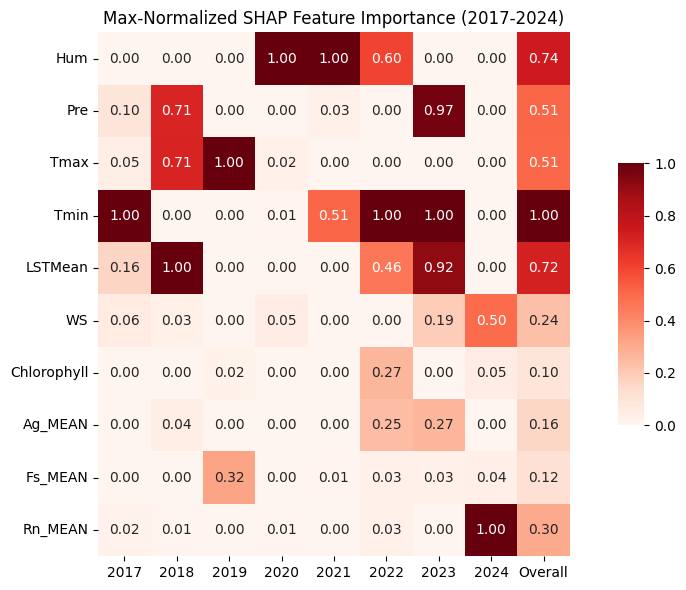

In [238]:
# this is the heatmap, along with the added column at the end. 

fig, ax = plt.subplots(figsize=(10,6))

plt.rcParams.update({'font.size': 10})

sns.heatmap(df_save, cmap="Reds", annot=True, fmt=".2f", square=True, cbar=True, cbar_kws={"shrink": 0.5, "aspect": 10})

ax.set_ylabel(None)

ax.tick_params(axis="x",labelsize=10, rotation=0)

plt.title("Max-Normalized SHAP Feature Importance (2017-2024)")
plt.tight_layout()

plt.savefig("Max-Normalized SHAP Feature Importance (2017-2024) True Data")


In [239]:
df_save.to_csv("true_data_param_importance_2017_to_2024.csv")

#### Optimal Threshold for Feature Selection - True Data

In [240]:
df_save = pd.read_csv("true_data_param_importance_2017_to_2024.csv").reset_index(drop=True)

In [241]:
df_save = df_save.rename(columns={"Unnamed: 0":"Feature"})
df_save

,Feature,2017,2018,2019,2020,2021,2022,2023,2024,Overall
0,Hum,0.000799,0.000000,0.000000,1.000000,1.000000,0.602207,0.000000,0.000000,0.739743
1,Pre,0.096678,0.706484,0.000000,0.000209,0.026667,0.000000,0.970035,0.000000,0.511559
2,Tmax,0.046052,0.710764,1.000000,0.024473,0.000000,0.000000,0.000000,0.000000,0.506221
3,Tmin,1.000000,0.000000,0.000000,0.007335,0.511434,1.000000,1.000000,0.000029,1.000000
4,LSTMean,0.160315,1.000000,0.000000,0.000079,0.000000,0.458212,0.915104,0.000000,0.720050
5,WS,0.061126,0.034259,0.000000,0.047900,0.000000,0.000000,0.189063,0.495813,0.235353
6,Chlorophyll,0.000000,0.000000,0.020588,0.000000,0.000000,0.268905,0.000000,0.053560,0.097491
7,Ag_MEAN,0.000000,0.043958,0.000000,0.003496,0.000000,0.245565,0.267532,0.000000,0.159302
8,Fs_MEAN,0.000000,0.000000,0.323152,0.001031,0.007694,0.026737,0.029092,0.035791,0.120353
9,Rn_MEAN,0.018112,0.007463,0.000000,0.005796,0.000000,0.027330,0.000000,1.000000,0.300870


In [242]:
df_elbow = df_save[["Feature","Overall"]]
df_elbow

,Feature,Overall
0,Hum,0.739743
1,Pre,0.511559
2,Tmax,0.506221
3,Tmin,1.000000
4,LSTMean,0.720050
5,WS,0.235353
6,Chlorophyll,0.097491
7,Ag_MEAN,0.159302
8,Fs_MEAN,0.120353
9,Rn_MEAN,0.300870


Important change: instead of using the top k features, we will use the top k + 4 features (to have six total predictors).

In [ ]:
sorted_features = df_elbow["Overall"].sort_values(ascending=False)
x = range(1, len(sorted_features)+1)
kneedle = KneeLocator(x, sorted_features, curve='convex', direction='decreasing')
k = kneedle.knee
print(f"k = {k}")

df_sorted = df_elbow.sort_values("Overall", ascending=False)

top_features = df_sorted["Feature"].iloc[:k].tolist()
print(top_features)

k = 6
['Tmin', 'Hum', 'LSTMean', 'Pre', 'Tmax', 'Rn_MEAN']


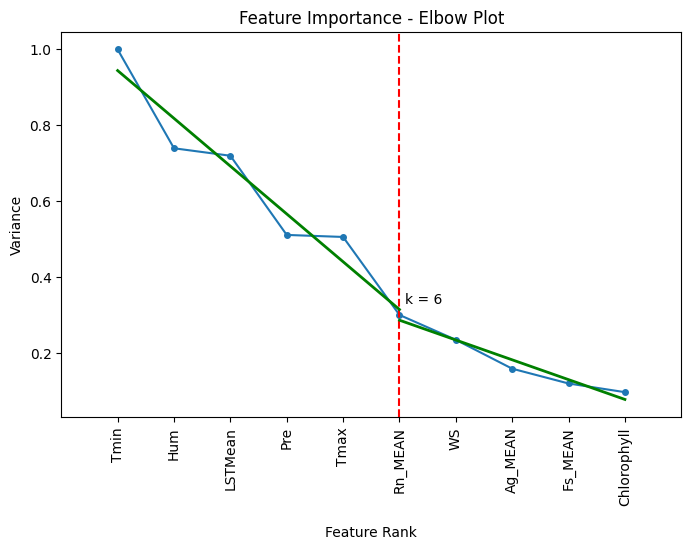

In [244]:
vals = df_elbow["Overall"].sort_values(ascending=False).values
features = df_sorted["Feature"].tolist()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(vals)+1), vals, marker='o',markersize=4)
plt.xticks(range(1, len(vals)+1), features, rotation=90)

plt.axvline(x=k,linestyle="--",color="red") 

plt.text(k + 0.1, vals[0]*0.33, f"k = {k}", rotation=0)
plt.xlim(0, len(vals)+1)

plt.xlabel("Feature Rank", labelpad=15)
plt.ylabel("Variance")
plt.title("Feature Importance - Elbow Plot")

# this wil help with interpretability
# array range for slope range
x = np.arange(1, len(vals)+1) 
x_1 = x[:k]
y_1 = vals[:k]
coef1 = np.polyfit(x_1, y_1, 1)
line1 = np.poly1d(coef1)
plt.plot(x_1, line1(x_1), color="green", linewidth=2)

x_2 = x[k-1:]
y_2 = vals[k-1:]
coef2 = np.polyfit(x_2, y_2, 1)
line2 = np.poly1d(coef2)
plt.plot(x_2, line2(x_2), color="green", linewidth=2)

plt.show()

note: use top 6 features instead for new model

In [245]:
print(f"Number of features in the final model: {len(top_features)}")
print(top_features)

Number of features in the final model: 6
['Tmin', 'Hum', 'LSTMean', 'Pre', 'Tmax', 'Rn_MEAN']


#### Bayesian Hyperparameter Tuning for TabNet Regressor

https://www.kaggle.com/code/liamhealy/bayesian-hyperparameter-tuning-in-python

Our objective function is RMSE (minimize RMSE).

1 iteration to be performed (backwards loocv):     
read this as [train] -> [target] 
1. [2017,2018,2019,2020,2021,2022,2023] -> [2024]
3. [2017,2018,2019,2020,2021,2022,2024] -> [2023]       
...     
8. [2018,2019,2020,2021,2022,2023,2024] -> [2017]

In [246]:
warnings.filterwarnings('ignore')
# Set Optuna logging level to WARNING (suppresses INFO messages)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_tabnet').setLevel(logging.ERROR)

In [247]:
def create_objective(X_train, X_test, y_train, y_test):
	def objective(trial):
		params = {
			'n_d': trial.suggest_int('n_d', 8, 64),
			'n_a': trial.suggest_int('n_a', 8, 64),
			'n_steps': trial.suggest_int('n_steps', 3, 10),
			'gamma': trial.suggest_float('gamma', 1.0, 2.0),
			'n_independent': trial.suggest_int('n_independent', 1, 5),
			'n_shared': trial.suggest_int('n_shared', 1, 5),
			'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
			'momentum': trial.suggest_float('momentum', 0.01, 0.4),
			'clip_value': trial.suggest_float('clip_value', 0.5, 2.0),
			'optimizer_params': {'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True)},
			'scheduler_params': {
				'step_size': trial.suggest_int('step_size', 10, 50),
				'gamma': trial.suggest_float('scheduler_gamma', 0.5, 0.99)
			},
			'scheduler_fn': torch.optim.lr_scheduler.StepLR,
			'mask_type': 'entmax'
		}

		model = TabNetRegressor(
			n_d=params['n_d'],
			n_a=params['n_a'],
			n_steps=params['n_steps'],
			gamma=params['gamma'],
			n_independent=params['n_independent'],
			n_shared=params['n_shared'],
			lambda_sparse=params['lambda_sparse'],
			momentum=params['momentum'],
			clip_value=params['clip_value'],
			optimizer_fn=torch.optim.Adam,
			optimizer_params=params['optimizer_params'],
			scheduler_params=params['scheduler_params'],
			scheduler_fn=torch.optim.lr_scheduler.StepLR,
			mask_type=params['mask_type'],
			seed=25,
			verbose=0
		)

		# training and testing data is always diff for each iteration
		# there will be 8 iterations total. 
		model.fit(
			X_train = X_train,
			y_train = y_train,
			eval_set = [(X_test, y_test)],
			eval_metric=["rmse"],
			max_epochs = 100,
			patience = 20,
			batch_size = 256,
			virtual_batch_size = 128
		)

		y_pred = model.predict(X_test)
		rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))

		return rmse
	return objective

In [248]:
def optimization_current_dataset(X_train, X_test, 
																 y_train, y_test, 
																 n_trials=50, 
																 study_name="tabnet_study"):
	'''
	This will be used for when I change my train/test data each iteration.
	I will append the dict result to the ``results`` list in the next cell.  
	'''
	# storing the current iteration reults.

	objective = create_objective(X_train, X_test, y_train, y_test)

	study = optuna.create_study(
		direction='minimize',
		# BO algorithm -> Tree-structured Parzen Estimator
		sampler=TPESampler(seed=25),
		study_name=study_name
  )

	# this is where the optimization takes place.
	study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

	best_params = study.best_params

	final_model = TabNetRegressor(
		n_d=best_params['n_d'],
		n_a=best_params['n_a'],
		n_steps=best_params['n_steps'],
		gamma=best_params['gamma'],
		n_independent=best_params['n_independent'],
		n_shared=best_params['n_shared'],
		lambda_sparse=best_params['lambda_sparse'],
		momentum=best_params['momentum'],
		clip_value=best_params['clip_value'],
		optimizer_params={'lr': best_params['lr']},
		scheduler_params={
				'step_size': best_params['step_size'],
				'gamma': best_params['scheduler_gamma']
		},
		scheduler_fn=torch.optim.lr_scheduler.StepLR,
		mask_type='entmax',
		seed=25,
		verbose=0
	)
    
	final_model.fit(
		X_train=X_train,
		y_train=y_train,
		eval_set=[(X_test, y_test)],
		eval_metric=['rmse'],
		max_epochs=200,
		patience=30,
		batch_size=256,
		virtual_batch_size=128
	)

	dict = {
		'best_params': best_params,
    'best_rmse': study.best_value,
		'model': final_model,
		'study': study
	}
	
	return dict

In [250]:
dfs[1]

,Unnamed: 0,County,County.1,2018,Cases_2018,Hum_18,Pre_18,Tmax_18,Tmin_18,LSTMean_2018,WS_18,Chlorophyll_2018,Ag_MEAN_2018,Fs_MEAN_2018,Rn_MEAN_2018,Cases_normalized_2018
0,0,Adams,Adams,65623,0,85.175008,4.235708,29.337400,18.110860,23.920,3.835810,1.411057,0.74,0.78,0.76,0.000000
1,1,Alexander,Alexander,6041,0,94.912456,3.769077,30.325177,19.718449,24.600,3.098565,1.386317,0.78,0.85,0.65,0.000000
2,2,Bond,Bond,16637,1,93.621653,4.407458,29.674914,18.442979,24.440,3.747461,1.782202,0.78,0.82,0.79,6.010699
3,3,Boone,Boone,53480,0,96.524731,5.729556,26.586884,14.930396,22.085,3.876066,1.282975,0.72,0.75,0.73,0.000000
4,4,Brown,Brown,6563,0,89.385441,3.943914,29.171971,17.449039,23.920,3.916484,1.664358,0.77,0.82,0.78,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,Whiteside,Whiteside,55553,1,92.851781,5.038716,27.627556,16.182203,23.050,3.535644,1.306419,0.73,0.76,0.69,1.800083
98,98,Will,Will,691149,4,93.494931,3.687957,28.110820,16.199878,24.895,3.675530,1.018075,0.72,0.73,0.77,0.578746
99,99,Williamson,Williamson,66982,1,94.437342,4.231876,30.066093,19.262134,25.015,2.905787,5.228341,0.79,0.82,0.72,1.492938
100,100,Winnebago,Winnebago,283630,1,96.142162,6.342099,26.554601,15.087235,22.515,3.875833,1.299643,0.74,0.77,0.76,0.352572


In [251]:
# fixing shape issue
# keep consistent target col across dfs
clean_dfs = []

idx = 0
year = 2017
for df in dfs:
	df_year = dfs[idx]

	# -- SET TARGET COLUMN --
	df_year["target"] = df_year[f"Cases_normalized_{year}"]
	df_year = df_year.drop(columns=[f'Cases_normalized_{year}', 'Unnamed: 0', 
																 'County', 'County.1',
																 f'{year}', f'Cases_{year}'])

	clean_dfs.append(df_year)

	idx += 1
	year += 1

In [252]:
clean_dfs[0].columns

Index(['Hum_17', 'Pre_17', 'Tmax_17', 'Tmin_17', 'LSTMean_2017', 'WS_17',
       'Chlorophyll_2017', 'Ag_MEAN_2017', 'Fs_MEAN_2017', 'Rn_MEAN_2017',
       'target'],
      dtype='object')

In [253]:
clean_dfs_standardized = []

for df in clean_dfs:
    df_copy = df.copy()
    # Remove year suffixes: Hum_17 -> Hum, LSTMean_2017 -> LSTMean
    df_copy.columns = df_copy.columns.str.replace(r'_\d{2,4}$', '', regex=True)
    clean_dfs_standardized.append(df_copy)

clean_dfs = clean_dfs_standardized

In [254]:
clean_dfs[0].columns

Index(['Hum', 'Pre', 'Tmax', 'Tmin', 'LSTMean', 'WS', 'Chlorophyll', 'Ag_MEAN',
       'Fs_MEAN', 'Rn_MEAN', 'target'],
      dtype='object')

In [255]:
results = []
# dfs_testing = [df_2017, df_2018, df_2019]

years = np.arange(2017, 2025)

# will run from 0 -- 2017 to 7 -- 2024 (0 indexed starts at 2017)
# reversing the index so iteration 1 starts with 
for test_idx in range(len(clean_dfs) - 1, -1, -1):
	# this is storing the top 13 parameters from the feature selection section
	top_features_copy = top_features.copy()

	test_df = clean_dfs[test_idx]

	train_dfs_list = [clean_dfs[i] for i in range(len(clean_dfs)) if i != test_idx]
	train_dfs = pd.concat(train_dfs_list, ignore_index=True)

	test_year = years[test_idx]
	train_years = [years[i] for i in range(len(clean_dfs)) if i != test_idx]

	X_train = train_dfs[top_features_copy].values
	y_train = train_dfs["target"].values.reshape(-1, 1)

	X_test = test_df[top_features_copy].values
	y_test = test_df["target"].values.reshape(-1, 1)

	# =========== above testing is done ===========

	iter_results_dict = optimization_current_dataset(X_train, X_test, y_train, y_test, study_name=f"tabnet_study_target_{test_year}")
	iter_results_dict["training"] = train_years
	iter_results_dict["testing"] = test_year 

	results.append(iter_results_dict)

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 28.69939

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 36.65219

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 15.76449
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 1.53939

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_rmse = 8.01643

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_rmse = 56.42138

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 2.43269

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_rmse = 0.60514
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 1.52679

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_rmse = 23.24499

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 2.24396


  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 14.00461

Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_0_rmse = 1.82627

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_rmse = 15.30036

Early stopping occurred at epoch 60 with best_epoch = 40 and best_val_0_rmse = 7.81399
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 2.06377
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 8.39269

Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_0_rmse = 1.38038

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 13.95809
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_rmse = 2.07945

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 18.97439

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_r

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 6.73804
Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_val_0_rmse = 5.96873

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 9.46215

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 1.21666

Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_rmse = 13.76504
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_rmse = 14.63527

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.82673

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 2.56594

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_rmse = 16.24746

Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_0_rmse = 20.16414

Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_0_rmse = 0.72333

E

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 60 with best_epoch = 40 and best_val_0_rmse = 4.72729

Early stopping occurred at epoch 55 with best_epoch = 35 and best_val_0_rmse = 3.63104

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 13.73195

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_rmse = 1.94316

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 3.44564
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 14.7259

Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_rmse = 0.75192

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 0.58903

Early stopping occurred at epoch 68 with best_epoch = 48 and best_val_0_rmse = 4.48554
Stop training because you reached max_epochs = 100 with best_epoch = 85 and best_val_0_rmse = 9.53703

Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_rmse = 1.26201

Ea

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 39.30585

Early stopping occurred at epoch 56 with best_epoch = 36 and best_val_0_rmse = 9.67887

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_rmse = 25.38936

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 15.19516

Early stopping occurred at epoch 89 with best_epoch = 69 and best_val_0_rmse = 3.93118
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 9.26184

Early stopping occurred at epoch 74 with best_epoch = 54 and best_val_0_rmse = 0.70242

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 1.46246
Stop training because you reached max_epochs = 100 with best_epoch = 81 and best_val_0_rmse = 2.4213

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_rmse = 20.84356

Early stopping occurred at epoch 80 with best_epoch = 60 and best_val_0_rmse = 0.48889

E

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 15.04344

Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_rmse = 5.31613

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 42.5017

Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_rmse = 4.58656

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 2.1387
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 15.47527

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 2.38976

Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_rmse = 5.06185

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 40.33478

Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_0_rmse = 14.59886

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_rmse = 16.77935

Early stopping 

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 10.07245

Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_0_rmse = 2.32389

Early stopping occurred at epoch 70 with best_epoch = 50 and best_val_0_rmse = 6.32949

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 2.01495

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 3.41574
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_val_0_rmse = 11.18462

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 2.08642

Early stopping occurred at epoch 63 with best_epoch = 43 and best_val_0_rmse = 2.56392
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 4.41193

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_rmse = 36.29029

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 2.02518

E

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 26.26567

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 18.96949

Early stopping occurred at epoch 91 with best_epoch = 71 and best_val_0_rmse = 4.87991

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 3.70785

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 20.53039

Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_rmse = 35.7673

Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_rmse = 1.46162

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_rmse = 1.24475
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 1.68564
Stop training because you reached max_epochs = 100 with best_epoch = 84 and best_val_0_rmse = 7.09487

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_rmse = 1.64389

E

In [256]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: (714, 6) y_train: (714, 1)


In [257]:
# save models and everything as pickle file 
with open('true_data_tabnet_results.pkl', 'wb') as f:
	pickle.dump(results, f)

In [2]:
# to load results later
with open('true_data_tabnet_results.pkl', 'rb') as f:
	pickle_results = pickle.load(f)

#### Best Model:

In [5]:
for i, n in enumerate(pickle_results):
	print(f"index: {i}")
	print(f"best rmse: {n["best_rmse"]}")
	print("")

index: 0
best rmse: 0.6141898684659107

index: 1
best rmse: 1.1475950896517473

index: 2
best rmse: 0.7056189738158226

index: 3
best rmse: 0.6090844288309968

index: 4
best rmse: 0.6494612807102036

index: 5
best rmse: 1.458847783971026

index: 6
best rmse: 1.4096880623325245

index: 7
best rmse: 1.0857749988151977



In [7]:
best_model = pickle_results[3]
best_model


{'best_params': {'n_d': 44,
  'n_a': 20,
  'n_steps': 4,
  'gamma': 1.2102005539702927,
  'n_independent': 4,
  'n_shared': 5,
  'lambda_sparse': 8.087294871572049e-05,
  'momentum': 0.39886589131490846,
  'clip_value': 0.8873087670497137,
  'lr': 0.09913286552131131,
  'step_size': 43,
  'scheduler_gamma': 0.7780085959676584},
 'best_rmse': 0.6090844288309968,
 'model': TabNetRegressor(n_d=44, n_a=20, n_steps=4, gamma=1.2102005539702927, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=4, n_shared=5, epsilon=1e-15, momentum=0.39886589131490846, lambda_sparse=8.087294871572049e-05, seed=25, clip_value=0.8873087670497137, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.09913286552131131}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 43, 'gamma': 0.7780085959676584}, mask_type='entmax', input_dim=6, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 'study': <o

In [8]:
best_model["model"]

,n_d,44
,n_a,20
,n_steps,4
,gamma,1.2102005539702927
,cat_idxs,[]
,cat_dims,[]
,cat_emb_dim,[]
,n_independent,4
,n_shared,5
,epsilon,1e-15
,momentum,0.39886589131490846


In [9]:
model = best_model["model"]

print(f"best model training years: { [int(val) for val in best_model["training"]] }")
print(f"best model test year: {best_model["testing"]}")

best model training years: [2017, 2018, 2019, 2020, 2022, 2023, 2024]
best model test year: 2021


In [263]:
top_features_copy = top_features.copy()

X_test = test_df[top_features_copy].values
y_test = test_df["target"].values.reshape(-1, 1)

y_pred = model.predict(X_test).reshape(-1)
y_true = y_test.reshape(-1)

In [264]:
rmse = root_mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

In [268]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 1.4173323767367385
MAE: 0.7249556258696029
R^2: -0.37514286668154795


In [266]:
print(y_true.mean())
print(y_true.std())
print(y_true.var())

0.40268195944829416
1.20864232296155
1.4608162648538916
